# Homework 3

## FINM 36700 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

**Students**

Adriana Mata <admata@uchicago.edu>

Jason Wang <jasonwang@uchicago.edu>

Sergei Tikhonov <tikhonov@uchicago.edu>

Neil Liu <xinyil2@uchicago.edu>

## HBS Case

### *The Harvard Management Company and Inflation-Indexed Bonds*

In [1]:
import os
import pandas as pd
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from arch.univariate import GARCH
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('barnstable_analysis_data.xlsx', sheet_name = 'data', index_col = 0)
data.fillna(method='ffill', inplace=True)
data['Excess SPY Returns'] = data['SPX'] - data['TB1M'] 
excess_return = data['Excess SPY Returns']

# 1. Historic VaR.


Starting at $t = 61$, calculate the historic-based VaR, based on the expanding sample from period 1 (Jan 1926) to $t − 1$. By historic VaR, we mean simply taking the 5th quantile for the historic sample up to time $t − 1$. Of course, a sample size that is not a multiple of 100 will require some interpolation to get a 5th quantile. Your statistical package should handle this fine.

Denote this as $\tilde{r}^{VaR,.05}_{t,historic}$ , which is the best estimate of the $time-t$ VaR based on data through $t−1$.

**(a) Plot $\tilde{r}^{VaR,.05}_{t,historic}$ over time.**

**(b) Calculate the frequency of periods in which $\tilde{r}^t < \tilde{r}^{VaR,.05}_{t,historic}$**

**(c) What drawbacks do you see in this historic VaR?**

In [3]:
def frequency_calc(VaR):
    """
    Function calculates r < r^VAR
    """
    
    numerator = sum(excess_return.loc[VaR.index] < VaR)
    denominator = len(VaR.index)
    freq = numerator / denominator
    
    return round(freq, 4) 

Historic frequency is 3.15%


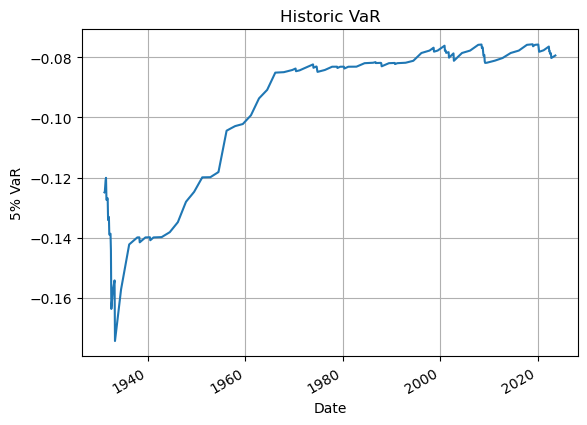

In [4]:
historic_VaR = excess_return.shift().expanding(min_periods = 60).quantile(.05).dropna()

historic_VaR.plot()
plt.grid(visible=1)
plt.title('Historic VaR')
plt.xlabel('Date')
plt.ylabel('5% VaR')

print(f'Historic frequency is {frequency_calc(historic_VaR) * 100}%');

The frequency of periods in which $\tilde{r}^t < \tilde{r}^{VaR,.05}_{t,historic}$ is 3.15%

**Backtest**: Backtesting is a process in which historical data is used to assess the accuracy and reliability of a VaR model. It involves comparing the calculated VaR with the actual outcomes over time to see if the VaR model is performing as expected.

The output 3.15% represents the actual losses or the percentage of losses experienced during the period being tested. Basically, during the backtesting period, the losses exceeded the 5% VaR estimate, and the actual losses amounted to 3.15% of the portfolio's value.

The portfolio's actual losses were higher than expected based on the VaR metric. This could suggest that the VaR model may need adjustments, or it could be a normal outcome given the inherent uncertainties in financial markets.


**Drawbacks of Historic VaR**

1. Historical VaR looks at only the historical data while estimating the losses in the future, which may no longer be representative.

2. Past significant changes equally contribute to the VaR but they may not be relevant anymore.  

3. Recent significant changes are treated equally with past dynamic since all the observations have the same weights. 


# 2. Volatility

We will calculate a time-series of volatility estimates using a few different methods. For each, we use $\sigma_t$ to denote our estimate of the $time-t$ return volatility, as based on data over periods 1 (Jan 1926) through $t − 1$, but not including $t$ itself.

* Expanding Series:
$$\sigma^2_{t,expanding} = \frac{1}{t-1}\Sigma^{t-1}_{\tau=1}\tilde{r}^2_\tau $$

Begin the calculation at $t = 61$, so that the first estimate is based on 60 data points.

* Rolling Window:
$$\sigma^2_{t,rolling} = \frac{1}{m}\Sigma^{m}_{l=1}\tilde{r}^2_{t-l} $$

Use $m = 60$, and begin the calculation at the t = 61, (so that the calculation has a full 60 data points.)

**(a) For each of these three methods, plot $\sigma_t$. (Plot the vol, not the variance.)**

**(b) For each method, calculate the 5th percentile, 1-month-ahead VaR. We use a slight simplification of the normal VaR formula, by dropping $\mu$ from that formula, and rounding the normal distribution z-score to -1.65.**

**(c) For each of these three vol-based VaR estimates, calculate the frequency of periods in which**
$\tilde{r}^t < \tilde{r}^{VaR,.05}_{t,vol}$

**(d) Compare and contrast your results among each other and relative to the historic method in the previous problem.**

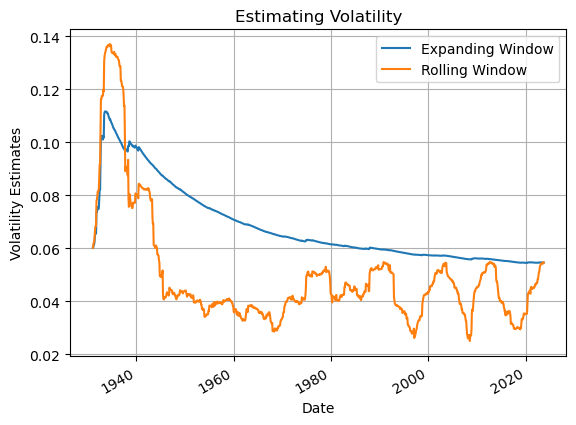

In [5]:
# Expanding Series:
stand_dev = np.sqrt((excess_return**2).shift().expanding(60).mean().to_frame('Expanding Window'))

# Rolling Window:
stand_dev['Rolling Window'] = np.sqrt((excess_return**2).shift().rolling(60).mean())

# Plotting: 
stand_dev.plot()
plt.grid(visible=1)
plt.title('Estimating Volatility')
plt.ylabel('Volatility Estimates')
plt.xlabel('Date');

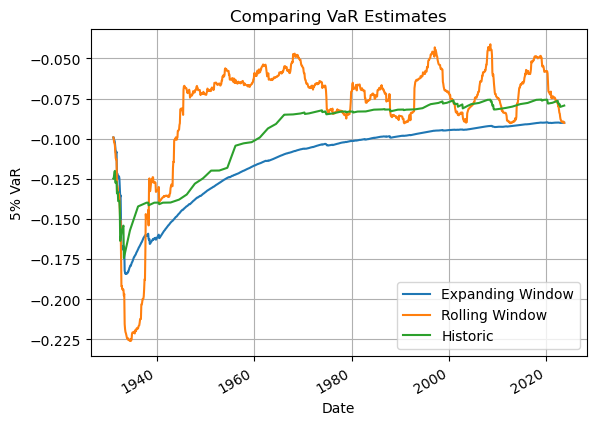

In [6]:
VaR = -1.65 * stand_dev
VaR['Historic'] = historic_VaR
VaR.dropna(inplace=True)

VaR.plot()
plt.grid(visible=1)
plt.title('Comparing VaR Estimates')
plt.xlabel('Date')
plt.ylabel('5% VaR');

In [7]:
VaR_freq = pd.DataFrame(None, columns = ['Expanding Window', 'Rolling Window', 'Historic'], index=['Frequancy'])
for col_name in VaR:
    
    VaR_freq.loc[:, col_name] = frequency_calc(VaR[col_name])

display(VaR_freq.style.format('{:,.2%}'))

,Expanding Window,Rolling Window,Historic
Frequancy,1.80%,4.95%,3.15%


**Model Comparison:**

The **Expanding Window Frequency** which resulted in 1.80% indicates the frequency of events where the returns were below the VaR threshold. The expanding window approach calculates this frequency over a dataset that continuously expands over time.

The **Rolling Window Frequency** which resulted in 4.95% calculates the frequency using a fixed-size window that moves through the dataset over time. So, approximately 4.95% of the observations have returns below the VaR threshold. This method considers a limited and rolling historical dataset to calculate the frequency.

The **Historic Frequency** which resulted in 3.15%, is the simplest approach, and it calculates the frequency of returns below the VaR threshold using the entire historical dataset. The value indicates that, historically, about 3.15% of the observations have returns below the VaR threshold.

Clearly, rolling window is a much better estimate because it place more weight on the most recent observations, and hence is quicker to react to high volatilities than other methods.

# 3. CVar

Re-do the previous two problems, but this time calculating CVaR instead of VaR, (still for q = .05.) That is, calculate CVaR for

* the empirical cdf
* the normal model, using expanding volatility estimates 
* the normal model, using rolling volatility estimates

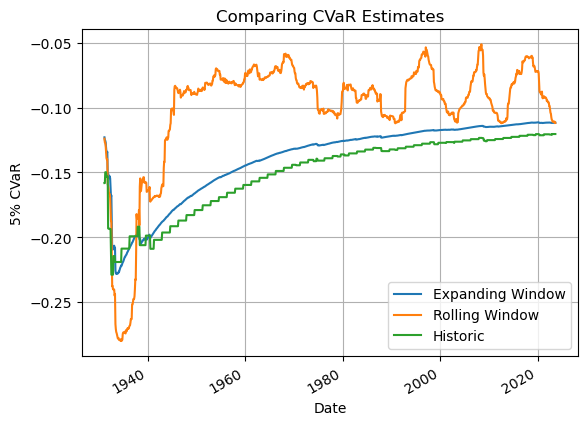

In [8]:
historic_CVaR = []

for t in range(excess_return.shape[0]):
    if t < 61:
        historic_CVaR.append(np.nan)
    else:
        window = excess_return[:t-1]
        CVaR = window[window < window.quantile(0.05)].mean()
        historic_CVaR.append(CVaR)
    
scaling_for_vol = norm.pdf(1.65) / 0.05
CVaR = -scaling_for_vol * stand_dev
CVaR['Historic'] = historic_CVaR
CVaR.dropna(inplace=True)

CVaR.plot()
plt.grid(visible=1)
plt.title('Comparing CVaR Estimates')
plt.ylabel('5% CVaR')
plt.xlabel('Date');

In [9]:
CVaR_freq = pd.DataFrame(None, columns = ['Expanding Window', 'Rolling Window', 'Historic'], index=['Frequancy'])
for col_name in VaR:
    
    CVaR_freq.loc[:, col_name] = frequency_calc(CVaR[col_name])

display(CVaR_freq.style.format('{:,.2%}'))

,Expanding Window,Rolling Window,Historic
Frequancy,0.90%,2.88%,0.81%


**Model Comparison**:

The **Expanding Window Frequency** which resulted in 0.90% indicates the frequency of events where the returns were below the VaR threshold. The expanding window approach calculates this frequency over a dataset that continuously expands over time.

The **Rolling Window Frequency** which resulted in 2.88% calculates the frequency using a fixed-size window that moves through the dataset over time. So, approximately 2.88% of the observations have returns below the VaR threshold. This method considers a limited and rolling historical dataset to calculate the frequency.

The **Historic Frequency** which resulted in 0.81%, is the simplest approach, and it calculates the frequency of returns below the VaR threshold using the entire historical dataset. The value indicates that, historically, about 0.81% of the observations have returns below the VaR threshold.

Clearly, rolling window is a much better estimate because it place more weight on the most recent observations, and hence is quicker to react to high volatilities than other methods.

# 4. Extra

*We may discuss this after Midterm 1, but it is not part of the Midterm 1 material.*

For the VaR calculations of Problem 2.2, and 2.3 try using the following models to estimate volatility:
* Exponentially Weighted Moving Average (EWMA)

$$ \sigma_{t,EWMA}^2 = \theta\sigma_{t-1,EWMA}^2 + (1-\theta)\tilde{r}^2_{t-1} $$

Rather than estimating $\theta$, simply use $\theta = 0.97$, and initialize with $\sigma_1 = 0.15$.

* GARCH(1,1) model.
To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation implementation is fine.

You should be familiar with EWMA and GARCH from the August Review.

In [10]:
GARCH = arch_model(excess_return, vol='Garch', p=1, o=0, q=1, dist='Normal')
GARCH_model = GARCH.fit()
GARCH_model.params

Iteration:      1,   Func. Count:      6,   Neg. LLF: 47894645.183721885
Iteration:      2,   Func. Count:     16,   Neg. LLF: -1950.463412480511
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1950.4634158658437
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2


mu          0.007870
omega       0.000059
alpha[1]    0.100000
beta[1]     0.879999
Name: params, dtype: float64

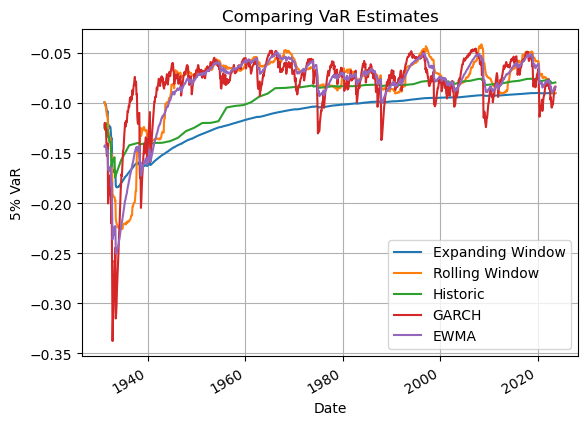

In [11]:
std = pd.DataFrame(None, columns = ['GARCH','EWMA'], index = excess_return.index)

std.iloc[0, :] = 0.15
theta = 0.97

for i in range(1, len(std)):
    std['EWMA'].iloc[i] = np.sqrt((std['EWMA'].iloc[i - 1] ** 2) * theta 
                                        + (1-theta)*(excess_return.iloc[i - 1] ** 2))
    std['GARCH'].iloc[i] = np.sqrt(GARCH_model.params['omega'] 
                                         + (std['GARCH'].iloc[i - 1] ** 2) * GARCH_model.params['beta[1]']\
                                         + GARCH_model.params['alpha[1]']*(excess_return.iloc[i - 1] ** 2))
    
std = std.loc[VaR.index]
VaR_full = -1.65 * std
VaR_full = pd.concat([VaR, VaR_full], axis=1)

VaR_full.plot()
plt.grid(visible=1)
plt.title('Comparing VaR Estimates')
plt.ylabel('5% VaR')
plt.xlabel('Date');

In [17]:
VaR_freq = pd.DataFrame(None, columns = ['Expanding Window', 'Rolling Window', 'Historic', 'GARCH','EWMA'], index=['Frequancy'])
for col_name in VaR_full:
    
    VaR_freq.loc[:, col_name] = frequency_calc(VaR_full[col_name])

display(VaR_freq.style.format('{:,.2%}'))

,Expanding Window,Rolling Window,Historic,GARCH,EWMA
Frequancy,1.80%,4.95%,3.15%,4.59%,4.32%


Model Comparison:

The **Expanding Window** indicates that the VaR is exceeded 1.80% of the time, which if sufficiently lower than 5%. As a result, this approach is the most underperformed among the considered methods.

The **Rolling Window** depicts that the VaR is exceeded approximately 4.95% of the time. This is the closest to 5% threshold, that is why this approache represents the best result among all the methods.

The **GARCH** model, known as Generalized Autoregressive Conditional Heteroskedasticity is a method used to model and forecast financial time series, particularly volatility. GARCH shows that VaR exceeded approximately 4.59% of the time, that means that there is a 4.59% chance that the actual losses in a financial portfolio will exceed the calculated VaR over a given time horizon, which is the second closest result to 5%.

The **EWMA** or Exponentially Weighted Moving Average model, is another method for estimating volatility in financial time series. The frequency row indicates that the VaR calculated using the EWMA method is exceeded approximately 4.32% of the time, which also shows a good fit among these methods. The EWMA method is a technique used to estimate the volatility or risk in financial time series data. It assigns more weight to recent observations and less weight to older observations. This approach is useful for capturing the changing nature of financial markets.

The **Historic frequency** column represents the VaR calculation using a historical method, which is often a simple percentile-based approach, with this method is exceeded approximately 3.15% of the time based on historical data.

To sum up, the frequencies from the table are an indication of how well each method performs in capturing extreme events in historical data. By definition, the number returns beyond the estimated VaR (5%) should be occuring with a frequancy close to 5%: The nearer a method is to a 5% frequency, the superior its performance.